## Задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [3]:
# imports
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier

In [38]:
df = pd.read_csv("HW_data.csv")
# convert ['channel', 'zip_code'] to dummy
one_hot_channel = pd.get_dummies(df['channel'])
one_hot_zip = pd.get_dummies(df['zip_code'])
df = df.join(one_hot_channel)
df = df.join(one_hot_zip)
df = df.drop(['channel', 'zip_code'], axis=1)

# rename columns
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})

# coding treatment
df['treatment'] = df['treatment'].apply(lambda i : 0 if i == 'No Offer' else 1)
df.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,Multichannel,Phone,Web,Rural,Surburban,Urban
0,10,142.44,1,0,0,1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,0,0,1,1,0,0
2,7,180.65,0,1,1,1,0,0,0,1,0,1,0
3,9,675.83,1,0,1,1,0,0,0,1,1,0,0
4,2,45.34,1,0,0,1,0,0,0,1,0,0,1


In [42]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['target'], axis=1), df['target'],
                                                    test_size=0.33, random_state=42)
treat_train = X_train.loc[:, 'treatment']
treat_test = X_test.loc[:, 'treatment']
X_train = X_train.drop(['treatment'], axis=1)
X_test = X_test.drop(['treatment'], axis=1)

models_results = {
    'approach': [],
    'uplift@30%': []
}

In [43]:
treat_train.value_counts()

1    28658
0    14222
Name: treatment, dtype: int64

## модель с признаком коммуникации (S learner)

uplift@30%: 0.0858


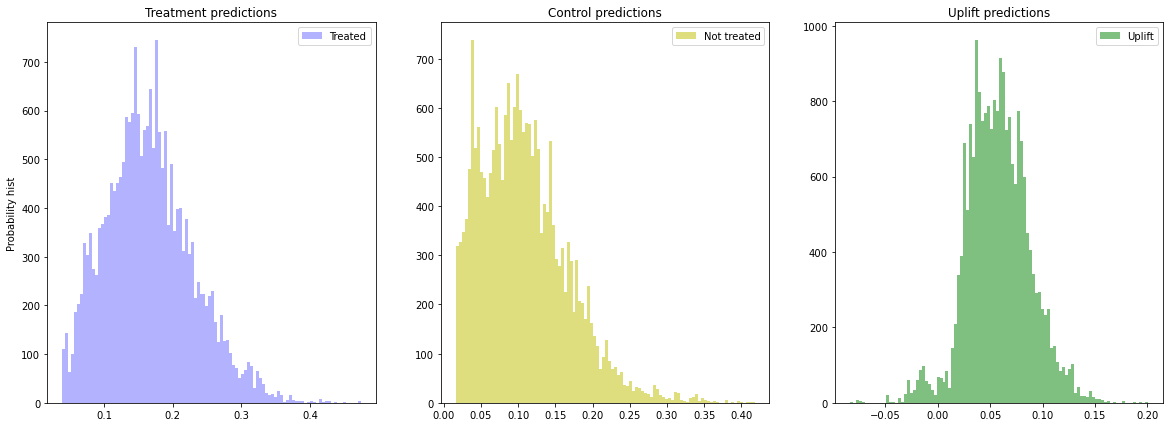

In [44]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);